In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import lib
import plotting
import markov_chain as mc
import markov_tools as mt

In [4]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [5]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [6]:
sequence_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_sequences.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels.p")
results_prefix = "[WIKIDATA]"

In [7]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,length,sequence,user_id
0,1511,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...",1
1,9,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...",1000036
2,7,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",1000078
3,9,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...",100008
4,44,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...",100012


In [8]:
null_model = 5

In [9]:
sequence = df['sequence'].values

In [14]:
plot_data = dict()
parameters = {}
likelihoods = {}
observations = {}

for order in tqdm(range(0, null_model + 1)):
    markov_chain = mc.MarkovChain(k=order, use_prior=False, reset=True, modus="mle")
    markov_chain.prepare_data(sequence)
    matrix = markov_chain.fit(sequence, ret=True)
    likelihoods[order] = markov_chain.loglikelihood()
    print(order, likelihoods[order])
    parameters[order] = markov_chain.parameter_count_
    observations[order] = markov_chain.observation_count_

    del markov_chain


lrts, pvals, dfs = mt.likelihood_ratio_test(likelihoods, parameters)
aics = mt.akaike_information_criterion(lratios=lrts, dfs=dfs, null_model=null_model)
bics = mt.bayesian_information_criterion(lratios=lrts, dfs=dfs, obs=observations, null_model=null_model)
print("#" * 30)
print("AICS", aics)
print("min index:", min(aics, key=aics.get))
print("BICS", bics)
print("min index:", min(bics, key=bics.get))
print("#" * 30)
plot_data[0] = {"aics": aics, "bics": bics}

0 -328691605.2923791
1 -156227362.3164143
2 -119723765.85351294
3 -100812492.53628625
4 -90931439.5787931
5 -82297961.92815939

##############################
AICS {0: -15745687625.27156, 1: -16090612239.22349, 2: -16163445192.149292, 3: -16193426938.783747, 4: -15860353044.698732, 5: 0.0}
min index: 3
BICS {0: -152102410646.14844, 1: -152447302746.38007, 2: -152518672581.89197, 3: -152482814044.9003, 4: -149186927387.63882, 5: 0.0}
min index: 2
##############################


In [17]:
store_path = os.path.join(cfg.get("directory", "results"), results_prefix + "information_criterion")

TypeError: 'AxesSubplot' object does not support indexing

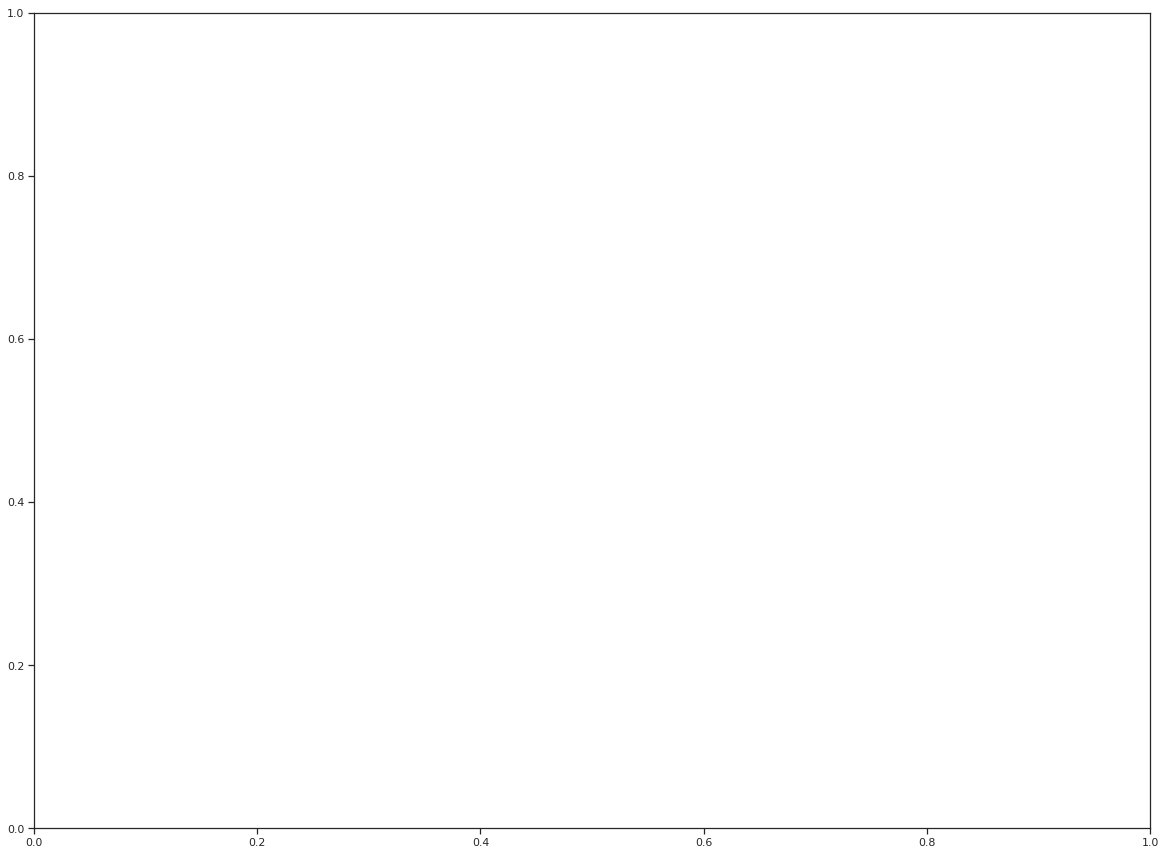

In [18]:
plotting.aics_bics(plot_data, store_path)